# Tutorial to parse PRDBv3.0 dataset

PYTHON LIBRARIES USED

In [1]:
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
from upsetplot import UpSet, generate_counts, plot

# to mask warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# PRDBv3 supplementary file name
prdbv3_supp_xlsx = "/home/shrikant/Projects/git_dev/PRDBv3_dataset/PRDBv3.0/PRDBv3_Supplementary_Tables.xlsx"

# PRDBv3 supplementary different sheets
supp_table1 = "Table_S1" # Supplementary table 1
supp_table2 = "Table_S2" # Supplementary table 2
supp_table3 = "Table_S3" # Supplementary table 3
rna_length_diff = "rna_length_diff" # Additional RNA length difference

PRDBv3.0 classes (structural, flexible and docking) starts by `#`  tag. 

Benchmark dataset is further classified into three categories based on i-rmsd values: 
1. Rigid body: i-rmsd < 1.5 Å
2. Semi-flexible: 1.5 Å ≤ i-rmsd < 3.0 Å
3. Fully flexible: i-rmsd ≥ 3.0 Å

In [3]:
# Read PRDBv3 supplementary table sheet1
prdbv3_supp_table1 = pd.read_excel(prdbv3_supp_xlsx, sheet_name= supp_table1, skiprows=[0])
# Skip the rows starts with #
PRDBv3_supp_tabS1_df = prdbv3_supp_table1[prdbv3_supp_table1['PDB ID'] != "#"]

In [4]:
PRDBv3_supp_tabS1_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197 entries, 2 to 211
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PDB ID        197 non-null    object 
 1   PDB           197 non-null    object 
 2   Chain         197 non-null    object 
 3   Protein_name  197 non-null    object 
 4   RNA_name      197 non-null    object 
 5   U_pro_PDB     187 non-null    object 
 6   U_RNA_PDB     37 non-null     object 
 7   BSA           197 non-null    float64
 8   Cα-rmsd       187 non-null    float64
 9   P-rmsd        37 non-null     float64
 10  i-rmsd_Cα     187 non-null    float64
 11  i-rmsd_P      37 non-null     float64
 12  i-rmsd_C+P    27 non-null     float64
 13  GDT_TS        187 non-null    float64
 14  LGA_S         187 non-null    float64
 15  Category      187 non-null    object 
 16  Sclass        197 non-null    object 
 17  Dcases        197 non-null    object 
dtypes: float64(8), object(10)
memory us

In [5]:
PRDBv3_supp_tabS1_df.head()

,PDB ID,PDB,Chain,Protein_name,RNA_name,U_pro_PDB,U_RNA_PDB,BSA,Cα-rmsd,P-rmsd,i-rmsd_Cα,i-rmsd_P,i-rmsd_C+P,GDT_TS,LGA_S,Category,Sclass,Dcases
2,1ASY_A:R,1ASY,A:R,‎S. cerevisiae aspartyl-tRNA synthetase,tRNA-Asp,1EOV:A,2TRA:A,4430.0,1.5,4.9,1.3,3.3,2.3,85.4,92.8,R,A,UU
3,1B23_P:R,1B23,P:R,T. aquaticus EF-TU,E. coli tRNA-Cys,1TUI:A,1U0B:A*,2616.0,10.0,7.2,13.3,13.0,13.2,50.3,47.7,F,A,UU
4,1C0A_A:B,1C0A,A:B,E. coli aspartyl-tRNA synthetase,tRNA-Asp,1EQR:A,1EFW:C*,4504.0,1.6,1.8,1.6,1.8,1.7,84.0,92.0,S,A,UU
5,1QTQ_A:B,1QTQ,A:B,E. coli glutaminyl-tRNA synthetase,tRNA-Gln,1NYL:A,3KNH:Y*,5202.0,1.6,4.8,1.8,6.4,4.0,86.7,93.0,S,A,UU
6,2BTE_A:B,2BTE,A:B,T. thermophilus leucyl-tRNA synthetase,tRNA-Leu,1OBC:A,2NQP:F*,3430.0,1.2,4.6,1.3,4.1,2.5,77.1,68.4,R,A,UU


In [6]:
# Total number of structures in PRDBv3.0
print(f"Number of structures in PRDBv3: {PRDBv3_supp_tabS1_df['PDB'].nunique()}\n")
# Number of structures in each structural class
print(f"Number of structures in each structural class:\n{PRDBv3_supp_tabS1_df.groupby('Sclass')['PDB'].nunique()}\n")
# Number of structures in each catagoery
print(f"Number of structures in each flexible class:\n{PRDBv3_supp_tabS1_df.groupby('Category')['PDB'].nunique()}\n")
# Number of structures in each docking cases
print(f"Number of structures in each Dcases:\n{PRDBv3_supp_tabS1_df.groupby('Dcases')['PDB'].nunique()}")

Number of structures in PRDBv3: 197

Number of structures in each structural class:
Sclass
A    40
B     9
C    62
D    86
Name: PDB, dtype: int64

Number of structures in each flexible class:
Category
F     29
R    117
S     41
Name: PDB, dtype: int64

Number of structures in each Dcases:
Dcases
BU     10
UB    160
UU     27
Name: PDB, dtype: int64


#### Figure 1: stattistics of different classes

In [7]:
# Except docking cases BU rest UU+BU class to plot
BU_case = PRDBv3_supp_tabS1_df[PRDBv3_supp_tabS1_df['Dcases'] != "BU"]

# Flexible classes
R =  BU_case[BU_case['i-rmsd_Cα'] <= 1.5 ]
S =  BU_case[(BU_case['i-rmsd_Cα'] >= 1.5) & (BU_case['i-rmsd_Cα'] < 3.0)]
X =  BU_case[BU_case['i-rmsd_Cα'] >= 3.0 ]

# Each structural classes in flexible classes
# Rigid class (R)
R_class_A = R[R['Sclass'] == "A"]
R_class_B = R[R['Sclass'] == "B"]
R_class_C = R[R['Sclass'] == "C"]
R_class_D = R[R['Sclass'] == "D"]
# Semi-flexible (S)
S_class_A = S[S['Sclass'] == "A"]
S_class_B = S[S['Sclass'] == "B"]
S_class_C = S[S['Sclass'] == "C"]
S_class_D = S[S['Sclass'] == "D"]
# Full-flexible (X)
X_class_A = X[X['Sclass'] == "A"]
X_class_B = X[X['Sclass'] == "B"]
X_class_C = X[X['Sclass'] == "C"]
X_class_D = X[X['Sclass'] == "D"]

r_class = [len(R_class_A), len(R_class_B), len(R_class_C), len(R_class_D)]
s_class = [len(S_class_A), len(S_class_B), len(S_class_C), len(S_class_D)]
f_class = [len(X_class_A), len(X_class_B), len(X_class_C), len(X_class_D)]
print(f'Flexible classes:\nR:{r_class}\nS:{s_class}\nF:{f_class}')

# Dictionary of flexible class as key and length in structural classes
docking_struct_flex = {
    'Rigid-body / R (i-rmsd < 1.5 Å)': r_class,
    'Semi-flexible / S (1.5 Å ≤ i-rmsd < 3.0 Å)': s_class,
    'Full-flexible / F (i-rmsd ≥ 3.0 Å)': f_class
}

Flexible classes:
R:[23, 3, 32, 61]
S:[8, 2, 16, 16]
F:[9, 3, 10, 7]


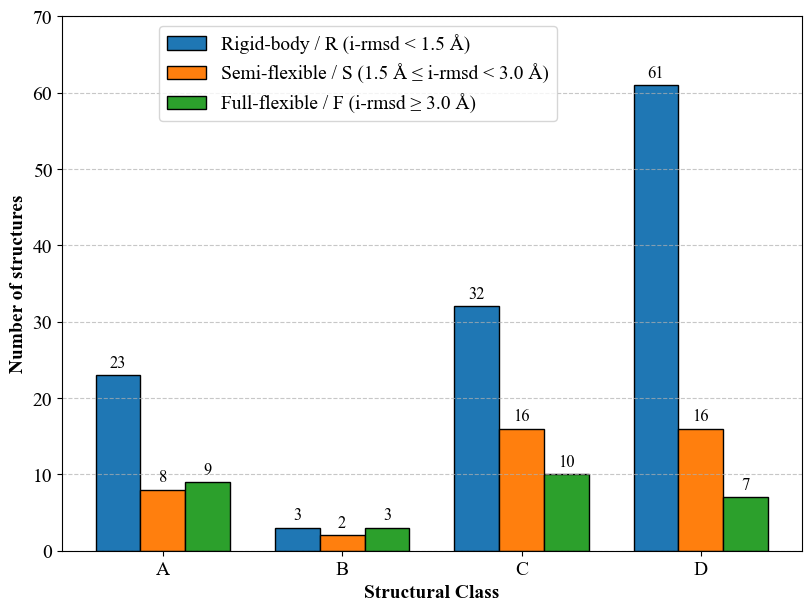

In [8]:
# Conformational flexibility across structural classes
plt.rcParams['font.family'] = "Times New Roman"
# Group structural class
flexible_class = ('A', 'B', 'C', 'D')

x = np.arange(len(flexible_class))  # the label locations
barWidth = 0.25  # the width of the bars
multiplier = 0

# Define subplots
fig, ax = plt.subplots(layout='constrained', figsize=(8, 6))

# Iterate through dictionary with custom colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
for idx, (attribute, measurement) in enumerate(docking_struct_flex.items()):
    offset = barWidth * multiplier
    rects = ax.bar(x + offset, measurement, barWidth, label=attribute, color=colors[idx], edgecolor="black")
    ax.bar_label(rects, padding=3, fontsize=12)
    multiplier += 1

# Add grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Add some text for labels, title, and custom x-axis tick labels, etc.
#ax.set_title('Relationship b/w Conformation and Structural Classes', fontweight='bold', fontsize=14, pad=20)
ax.set_ylabel('Number of structures', fontweight='bold', fontsize=14)
ax.set_xlabel('Structural Class', fontweight='bold', fontsize=14)
ax.set_xticks(x + barWidth, flexible_class, fontsize=14)
ax.set_yticklabels(np.arange(0, 70+1, 10), fontsize=14)
ax.set_xticklabels(flexible_class, fontsize=14)
ax.set_ylim(0, 70)
ax.legend(loc='upper center', bbox_to_anchor=(0.4, 1), fontsize=14)
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=11)

# Add subtitle
#fig.suptitle('Visualizing Conformational Flexibility Across Structural Classes', fontsize=12, fontweight='light', y=1.02)
# save the plot

#plt.savefig('/home/shrikant/Projects/git_dev/PRDBv3_dataset/figures/Figure_1.tiff', format='tiff', dpi=300)
#plt.savefig('/home/shrikant/Projects/git_dev/PRDBv3_dataset/figures/Figure_1.png', bbox_inches='tight', format='png', dpi=600)

# Show plot
plt.show()

#### PRDBv3.0: Protein-RNA affinity benchmark

In [9]:
# Read PRDBv3 supplementary table sheet1
prdbv3_supp_table2 = pd.read_excel(prdbv3_supp_xlsx, sheet_name= supp_table2, skiprows=[0])
# Skip the rows starts with #
PRDBv3_supp_tabS2_df = prdbv3_supp_table2[prdbv3_supp_table2['PDB ID'] != "#"]

In [10]:
PRDBv3_supp_tabS2_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105 entries, 2 to 117
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PDB ID            105 non-null    object 
 1   PDB               105 non-null    object 
 2   Chain             105 non-null    object 
 3   Protein_name      105 non-null    object 
 4   RNA_name          105 non-null    object 
 5   Crystal_RNA_len   105 non-null    float64
 6   Solution_RNA_len  105 non-null    float64
 7   Kd                105 non-null    float64
 8   Temperature (K)   105 non-null    float64
 9   pH                105 non-null    float64
 10  ΔG (kcal/mol)     105 non-null    float64
 11  Exp  Technique    105 non-null    object 
 12  BSA               105 non-null    float64
 13  Cα-rmsd           100 non-null    float64
 14  P-rmsd            22 non-null     float64
 15  i-rmsd_Cα         100 non-null    float64
 16  i-rmsd_P          22 non-null     float64
 17  Ca

In [11]:
PRDBv3_supp_tabS2_df.head()

,PDB ID,PDB,Chain,Protein_name,RNA_name,Crystal_RNA_len,Solution_RNA_len,Kd,Temperature (K),pH,...,Exp Technique,BSA,Cα-rmsd,P-rmsd,i-rmsd_Cα,i-rmsd_P,Category,Sclass,Dcases,PubMed ID
2,1ASY_A:R,1ASY,A:R,‎S. cerevisiae aspartyl-tRNA synthetase,tRNA-Asp,75.0,76.0,3.000000e-08,310.0,5.5,...,A,4430.0,1.5,4.9,1.3,3.3,R,A,UU,10452887
3,1QTQ_A:B,1QTQ,A:B,E. coli glutaminyl-tRNA synthetase,tRNA-Gln,75.0,76.0,3.600000e-07,310.0,5.2,...,D,5202.0,1.6,4.8,1.8,6.4,S,A,UU,15845537
4,2DRB_A:B,2DRB,A:B,A. fulgidus CCA-adding enzyme,tRNAminiCCA,35.0,73.0,6.700000e-08,298.0,8.5,...,C,3198.0,1.1,3.4,1.8,4.2,S,A,UU,14592988
5,2FMT_A:C,2FMT,A:C,E. coli methionyl-tRNAfmet transformylase,tRNAfmet,77.0,77.0,1.360000e-05,310.0,7.6,...,A,2940.0,1.2,2.3,0.9,2.5,R,A,UU,10089442
6,3HL2_AA'BB':E,3HL2,AA'BB':E,H. sapiens selenium transferase,tRNA-Sec,90.0,90.0,1.340000e-07,300.0,8.0,...,H,2186.0,0.6,5.2,1.3,6.0,R,A,UU,36929010


In [12]:
# Total number of structures in PRDBv3.0
print(f"Number of structures in binding affinity benchmark (PRDBv3): {PRDBv3_supp_tabS2_df['PDB'].nunique()}\n")
# Number of structures in each structural class
print(f"Number of structures in each structural class:\n{PRDBv3_supp_tabS2_df.groupby('Sclass')['PDB'].nunique()}\n")
# Number of structures in each catagoery
print(f"Number of structures in each flexible class:\n{PRDBv3_supp_tabS2_df.groupby('Category')['PDB'].nunique()}\n")
# Number of structures in each docking cases
print(f"Number of structures in each Dcases:\n{PRDBv3_supp_tabS2_df.groupby('Dcases')['PDB'].nunique()}")

Number of structures in binding affinity benchmark (PRDBv3): 105

Number of structures in each structural class:
Sclass
A    12
B     6
C    35
D    52
Name: PDB, dtype: int64

Number of structures in each flexible class:
Category
F    18
R    60
S    22
Name: PDB, dtype: int64

Number of structures in each Dcases:
Dcases
BU     5
UB    83
UU    17
Name: PDB, dtype: int64


#### Protein-RNA affinity dataset statistics

In [13]:
# Except docking cases BU rest UU+BU class to plot
BU_case = PRDBv3_supp_tabS2_df[PRDBv3_supp_tabS2_df['Dcases'] != "BU"]

# Flexible classes
R =  BU_case[BU_case['i-rmsd_Cα'] <= 1.5 ]
S =  BU_case[(BU_case['i-rmsd_Cα'] >= 1.5) & (BU_case['i-rmsd_Cα'] < 3.0)]
X =  BU_case[BU_case['i-rmsd_Cα'] >= 3.0 ]

# Each structural classes in flexible classes
# Rigid class (R)
R_class_A = R[R['Sclass'] == "A"]
R_class_B = R[R['Sclass'] == "B"]
R_class_C = R[R['Sclass'] == "C"]
R_class_D = R[R['Sclass'] == "D"]

# Semi-flexible (S)
S_class_A = S[S['Sclass'] == "A"]
S_class_B = S[S['Sclass'] == "B"]
S_class_C = S[S['Sclass'] == "C"]
S_class_D = S[S['Sclass'] == "D"]
# Full-flexible (X)
X_class_A = X[X['Sclass'] == "A"]
X_class_B = X[X['Sclass'] == "B"]
X_class_C = X[X['Sclass'] == "C"]
X_class_D = X[X['Sclass'] == "D"]

r_class = [len(R_class_A), len(R_class_B), len(R_class_C), len(R_class_D)]
s_class = [len(S_class_A), len(S_class_B), len(S_class_C), len(S_class_D)]
f_class = [len(X_class_A), len(X_class_B), len(X_class_C), len(X_class_D)]
print(f'Flexible classes:\nR:{r_class}\nS:{s_class}\nF:{f_class}')
affinity_struct_flex = {'Rigid / R: i-rmsd < 1.5 Å': r_class, 'Semi-flexible / S: 1.5 Å ≤ i-rmsd < 3.0 Å': s_class, 'Full-flexible / F: i-rmsd ≥ 3.0 Å': f_class}

Flexible classes:
R:[8, 2, 16, 35]
S:[3, 1, 8, 10]
F:[2, 2, 7, 7]


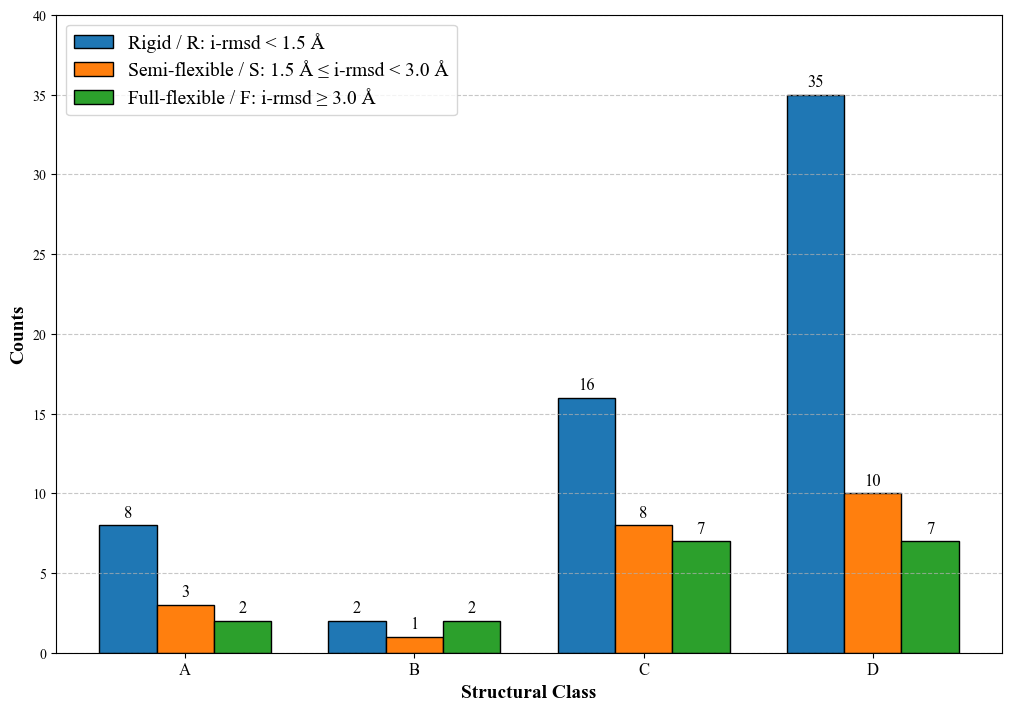

In [14]:
# Group structural class
flexible_class = ('A', 'B', 'C', 'D')

x = np.arange(len(flexible_class))  # the label locations
barWidth = 0.25  # the width of the bars
multiplier = 0

# Define subplots
fig, ax = plt.subplots(layout='constrained', figsize=(10, 7))

# Iterate through dictionary with custom colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
for idx, (attribute, measurement) in enumerate(affinity_struct_flex.items()):
    offset = barWidth * multiplier
    rects = ax.bar(x + offset, measurement, barWidth, label=attribute, color=colors[idx], edgecolor="black")
    ax.bar_label(rects, padding=3, fontsize=12)
    multiplier += 1

# Add grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Add some text for labels, title, and custom x-axis tick labels, etc.
#ax.set_title('Relationship b/w Conformation and Structural Classes', fontweight='bold', fontsize=14, pad=20)
ax.set_ylabel('Counts', fontweight='bold', fontsize=14)
ax.set_xlabel('Structural Class', fontweight='bold', fontsize=14)
ax.set_xticks(x + barWidth, flexible_class)
ax.set_xticklabels(flexible_class, fontsize=12)
ax.set_ylim(0, 40)
ax.legend(fontsize=14)
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=11)

# Add subtitle
#fig.suptitle('Visualizing Conformational Flexibility Across Structural Classes', fontsize=12, fontweight='light', y=1.02)
# save the plot
#plt.savefig('/home/shrikant/Projects/git_dev/PRDBv3_dataset/figures/affinity_structural_classes_plot.tiff', format='tiff', dpi=300)
#plt.savefig('/home/shrikant/Projects/git_dev/PRDBv3_dataset/figures/affinity_structural_classes_plot.png', format='png', dpi=600)

# Show plot
plt.show()

#### RNA length variability and binding affinity 

In [15]:
# Read PRDBv3 RNA lenths difference sheet
rna_lenth_df = pd.read_excel(prdbv3_supp_xlsx, sheet_name= rna_length_diff, skiprows=None)

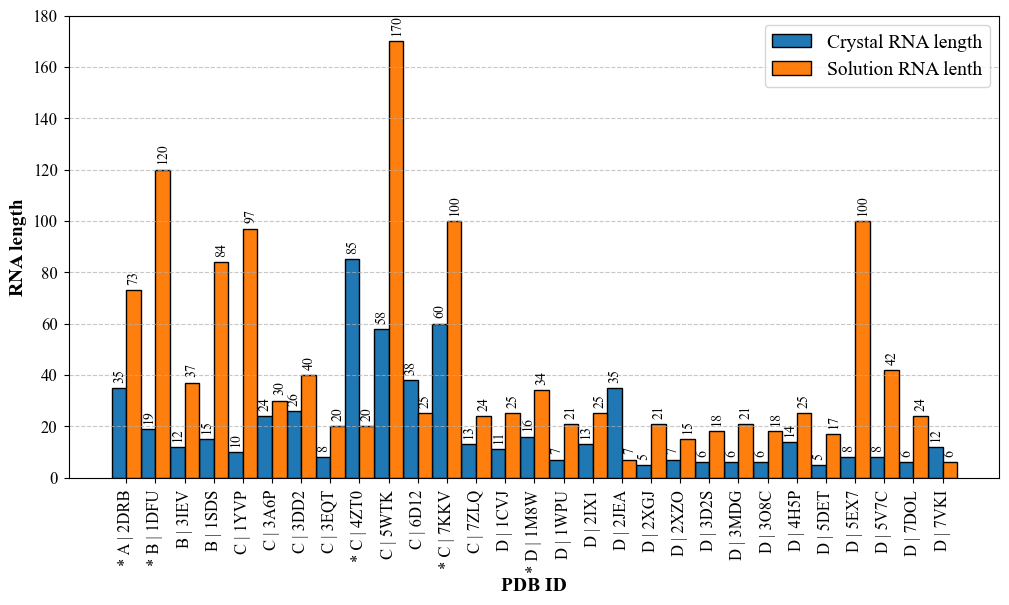

In [16]:
# RNA length variabilities
plt.rcParams['font.family'] = "Times New Roman"

# Define bar width and positions
bar_width = 0.5
x = np.arange(len(rna_lenth_df['PDB']))

# Create the plot with updated color scheme
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for "Crystal" and "Solution"
crystal_bars = ax.bar(x - bar_width / 2, rna_lenth_df['Crystal_RNA_len'], bar_width, label="Crystal RNA length", color="#1f77b4", edgecolor="black")
solution_bars = ax.bar(x + bar_width / 2, rna_lenth_df['Solution_RNA_len'], bar_width, label="Solution RNA lenth", color="#ff7f0e", edgecolor="black")

# Customize the plot
#ax.set_title("Comparison of RNA Lengths: Crystal vs. Solution", fontsize=14, fontweight="bold")
ax.set_xlabel("PDB ID", fontsize=14, fontweight="bold")
ax.set_ylabel("RNA length", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_ylim(0, 180)
ax.set_xticklabels(rna_lenth_df['labels'], rotation=90, fontsize=12, ha="center")
ax.set_yticklabels(np.arange(0, 181, 20), fontsize=12)
ax.legend(fontsize=14)
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.tick_params(axis="both", which="major", labelsize=12, pad=5)
plt.rcParams["font.monospace"]
# Add bar labels
for bars in (crystal_bars, solution_bars):
    ax.bar_label(bars, padding=4, fontsize=10, rotation=90)

# Add subtitle
#fig.suptitle('RNA length in crystal and solution', fontsize=12, fontweight='light', y=1.02)

# Show the plot
#plt.savefig('/home/shrikant/Projects/git_dev/PRDBv3_dataset/figures/Figure_4.tiff', format='tiff', dpi=300)
#plt.savefig('/home/shrikant/Projects/git_dev/PRDBv3_dataset/figures/Figure_4.png', bbox_inches='tight', format='png', dpi=600)

# show plot
plt.show()

# close the plot
plt.close()

### PRDBv3.0: RBPs domain from Pfam and InterPro

In [17]:
# Read PRDBv3 supplementary table sheet1
prdbv3_supp_table3 = pd.read_excel(prdbv3_supp_xlsx, sheet_name= supp_table3, skiprows=[0])
# Skip the rows starts with #
PRDBv3_supp_tabS4_df = prdbv3_supp_table3[prdbv3_supp_table3['PDB ID'] != "#"]

In [18]:
PRDBv3_supp_tabS4_df

,PDB ID,PDB,Chain,Protein_name,RNA_name,U_pro_PDB,U_RNA_PDB,Domain mapped to PDB chain,Domain_name,Domain_ID,UniProt_ID,Start,End,BSA,Protein,RNA,Catagory,Sclass,Dcases
2,1ASY_A:R,1ASY,A:R,‎S. cerevisiae aspartyl-tRNA synthetase,tRNA-Asp,1EOV:A,2TRA:A,1ASY:A,tRNA anti-codon,PF01336,P04802,109.0,197.0,1377,673.0,704.0,R,A,UU
3,1ASY_A:R,1ASY,A:R,‎S. cerevisiae aspartyl-tRNA synthetase,tRNA-Asp,1EOV:A,2TRA:A,1ASY:A,tRNA-synt 2,PF00152,P04802,227.0,552.0,2062,963.0,1099.0,R,A,UU
4,1B23_P:R,1B23,P:R,T. aquaticus EF-TU,E. coli tRNA-Cys,1TUI:A,1U0B*:A,1B23:P,GTP_EFTU,PF00009,Q01698,10.0,213.0,665,334.0,330.0,F,A,UU
5,1B23_P:R,1B23,P:R,T. aquaticus EF-TU,E. coli tRNA-Cys,1TUI:A,1U0B*:A,1B23:P,GTP_EFTU_D2,PF03144,Q01698,236.0,306.0,584,260.0,324.0,F,A,UU
6,1B23_P:R,1B23,P:R,T. aquaticus EF-TU,E. coli tRNA-Cys,1TUI:A,1U0B*:A,1B23:P,GTP_EFTU_D3,PF03143,Q01698,310.0,405.0,996,494.0,502.0,F,A,UU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,6HTU_ABC:DF,6HTU,ABC:DF,H. sapiens hStau1 dsRBD3-4,ARF1 RNA,NaN,6HU6:AE,6HTU:A,dsrm,PF00035,O95793,185.0,249.0,1397,715.0,682.0,NaN,C,BU
471,6HTU_ABC:DF,6HTU,ABC:DF,H. sapiens hStau1 dsRBD3-4,ARF1 RNA,NaN,6HU6:AE,6HTU:B,dsrm,PF00035,O95793,185.0,249.0,960,483.0,477.0,NaN,C,BU
472,6HTU_ABC:DF,6HTU,ABC:DF,H. sapiens hStau1 dsRBD3-4,ARF1 RNA,NaN,6HU6:AE,6HTU:C,dsrm,PF00035,O95793,287.0,352.0,873,450.0,423.0,NaN,C,BU
474,1LNG_A:B,1LNG,A:B,M. jannaschii SRP19,7S SRP RNA,NaN,1Z43:A,1LNG:A,SRP19,PF01922,Q58440,2.0,86.0,2331,1136.0,1195.0,NaN,D,BU


In [19]:
# Need columns to create DataFrame
pfam_domain = ['PDB', 'Chain', 'Domain mapped to PDB chain', 'Catagory', 'Sclass', 'Dcases', 'Domain_name', 'Domain_ID', 'UniProt_ID']
PRDBV3_domain_df = pd.DataFrame(PRDBv3_supp_tabS4_df, columns=pfam_domain)

In [20]:
# Total number of unique domains in PRDBv3.0
print(f"Number of unique domains in PRDBv3: {PRDBV3_domain_df['Domain_ID'].nunique()}\n")
# Number of unique domains in each structural class
print(f"Number of unique domains in each structural class:\n{PRDBV3_domain_df.groupby('Sclass')['Domain_ID'].nunique()}\n")
# Number of unique domains in each catagoery
print(f"Number of unique domains in each flexible class:\n{PRDBV3_domain_df.groupby('Catagory')['Domain_ID'].nunique()}\n")
# Number of unique domains in each docking cases
print(f"Number of unique domains in each Dcases:\n{PRDBV3_domain_df.groupby('Dcases')['Domain_ID'].nunique()}")

Number of unique domains in PRDBv3: 255

Number of unique domains in each structural class:
Sclass
A     64
B     12
C     91
D    104
Name: Domain_ID, dtype: int64

Number of unique domains in each flexible class:
Catagory
F     64
R    143
S     67
Name: Domain_ID, dtype: int64

Number of unique domains in each Dcases:
Dcases
BU     13
UB    211
UU     49
Name: Domain_ID, dtype: int64


<Figure size 1200x600 with 0 Axes>

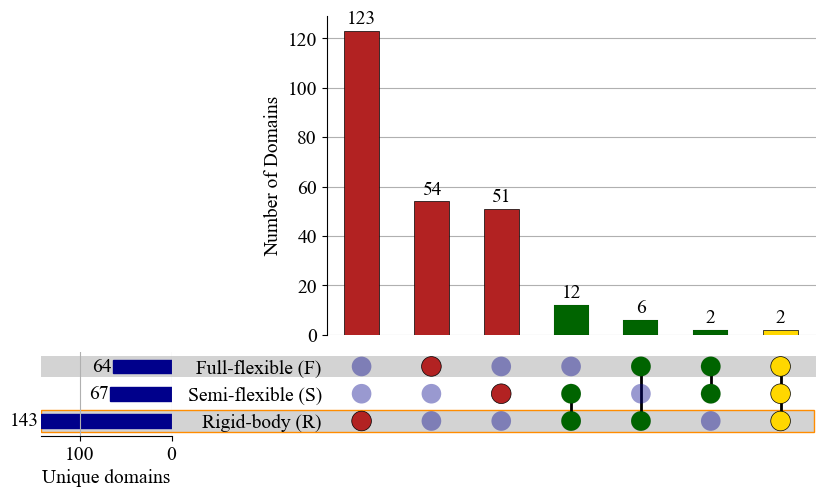

In [21]:
# Create a copy of the DataFrame to avoid modifying the original
df = PRDBV3_domain_df.copy()

# plot font style
plt.rcParams['font.family'] = "Times New Roman"

# Create a UpSet plot to visualize the overlaps between flexible catagories
# Unique domains in flexible catagory
domain_flex_R = df[df['Catagory'] == 'R']
domain_flex_S = df[df['Catagory'] == 'S']
domain_flex_F = df[df['Catagory'] == 'F']

# Convert the 'ID' columns to sets
set1 = set(domain_flex_R['Domain_ID'].unique()) 
set2 = set(domain_flex_S['Domain_ID'].unique())
set3 = set(domain_flex_F['Domain_ID'].unique())

# Combine sets into a DataFrame
set_names = ['Rigid-body (R)', 'Semi-flexible (S)', 'Full-flexible (F)']
all_elems = set1.union(set2).union(set3)
df = pd.DataFrame([[e in set1, e in set2, e in set3] for e in all_elems], columns=set_names)
df_up = df.groupby(set_names).size()

# Define figure size and style
fig = plt.figure(figsize=(12, 6))
plt.rcParams["font.size"] = 14
plt.rcParams["font.weight"] = "light"

# Create an UpSet plot
upset = UpSet(df_up, orientation='horizontal', show_counts='%d', sort_by='cardinality', min_subset_size=1, facecolor="darkblue",
              shading_color="lightgray", other_dots_color=0.4, element_size=None, intersection_plot_elements=10, totals_plot_elements=2)

# Customize the plot
upset.style_categories('Rigid-body (R)', shading_edgecolor="darkorange", shading_linewidth=1)
upset.style_subsets(min_degree=1, facecolor="firebrick", edgecolor="black", linewidth=0.5)
upset.style_subsets(min_degree=2, facecolor="darkgreen", edgecolor="black", linewidth=.05)
upset.style_subsets(min_degree=3, facecolor="gold", edgecolor="black", linewidth=0.5)

# Add labels to the plot
plot_result = upset.plot()
#plt.title("UpSet Plot of Protein-RNA Docking Benchmarks", fontsize=14, fontweight='light')

# Update plot labels with adjusted font sizes
plot_result['intersections'].set_ylabel('Number of Domains', fontsize=14)
plot_result['totals'].set_xlabel('Unique domains', fontsize=14)

# Adjust the plot layout
plt.subplots_adjust(top=0.85, bottom=0.15)

# Save figure
#plt.savefig('/home/shrikant/Projects/git_dev/PRDBv3_dataset/figures/Figure_S1.tiff', format='tiff', dpi=300, bbox_inches='tight')
#plt.savefig('/home/shrikant/Projects/git_dev/PRDBv3_dataset/figures/Figure_S1.png', format='png', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

# close the plot
plt.close()

The RRM and Trm5_N (PF00076 and PF18093) domains exhibits the rigid body to full-flexible coformational rearrangements.

In [22]:
print(f'Total 2 shared common domains between R, S and X:\n{set1.intersection(set2, set3)}')
#PRDBV3_domain_df[PRDBV3_domain_df['Domain_ID'] == 'PF00076']
PRDBV3_domain_df[PRDBV3_domain_df['Domain_ID'] == 'PF18093']

Total 2 shared common domains between R, S and X:
{'PF00076', 'PF18093'}


,PDB,Chain,Domain mapped to PDB chain,Catagory,Sclass,Dcases,Domain_name,Domain_ID,UniProt_ID
23,2ZZM,A:B,2ZZM:A,F,A,UU,Trm5_N,PF18093,Q58293
24,3HL2,AA'BB':E,3HL2:A,R,A,UU,Trm5_N,PF18093,Q58293
110,5WT1,A:C,5WT1:A,S,A,UB,Trm5_N,PF18093,Q9V2G1


In [23]:
print(f'Total 4 common domain present between S and F:\n{set2.intersection(set3)}')
PRDBV3_domain_df[PRDBV3_domain_df['Domain_ID'] == 'PF01386']

Total 4 common domain present between S and F:
{'PF05746', 'PF18093', 'PF00076', 'PF01386'}


,PDB,Chain,Domain mapped to PDB chain,Catagory,Sclass,Dcases,Domain_name,Domain_ID,UniProt_ID
38,1DFU,P:MN,1DFU:P,F,B,UU,Ribosomal_L25p,PF01386,P68919
39,1FEU,A:BC,1FEU:A,S,B,UU,Ribosomal_L25p,PF01386,P56930


In [24]:
print(f'Total 8 common domain present between R and X:\n{set1.intersection(set3)}')
PRDBV3_domain_df[PRDBV3_domain_df['Domain_ID'] == 'PF00579']

Total 8 common domain present between R and X:
{'PF00076', 'PF16198', 'PF00579', 'PF00271', 'PF00098', 'PF01509', 'PF00270', 'PF18093'}


,PDB,Chain,Domain mapped to PDB chain,Catagory,Sclass,Dcases,Domain_name,Domain_ID,UniProt_ID
72,1H3E,AA':B,1H3E:A,F,A,UB,tRNA-synt_1b,PF00579,P83453
79,1J1U,AA':B,1J1U:A,R,A,UB,tRNA-synt_1b,PF00579,Q57834
93,2AZX,AA':C,2AZX:A,R,A,UB,tRNA-synt_1b,PF00579,P23381


In [25]:
print(f'Total 14 common domain present between R and S:\n{set1.intersection(set2)}')
PRDBV3_domain_df[PRDBV3_domain_df['Domain_ID'] == 'PF01336']

Total 14 common domain present between R and S:
{'PF07652', 'PF00076', 'PF00680', 'PF00013', 'PF00749', 'PF00587', 'PF00152', 'PF01938', 'PF01248', 'PF04055', 'PF01436', 'PF18093', 'PF01336', 'PF02171'}


,PDB,Chain,Domain mapped to PDB chain,Catagory,Sclass,Dcases,Domain_name,Domain_ID,UniProt_ID
2,1ASY,A:R,1ASY:A,R,A,UU,tRNA anti-codon,PF01336,P04802
7,1C0A,A:B,1C0A:A,S,A,UU,tRNA_anti-codon,PF01336,P21889
99,3AMT,A:B,3AMT:A,R,A,UB,tRNA_anti-codon,PF01336,O28025
